In [1]:
import sys
sys.path.append('..')
from gamadhani.utils.utils import download_models, download_data
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from gamadhani.utils.generate_utils import load_audio_fns
from gamadhani.utils.utils import get_device
import gin
from functools import partial
import torch
import gamadhani.utils.pitch_to_audio_utils as p2a

from torch import nn

/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/x_transformers/x_transformers.py:445: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/x_transformers/x_transformers.py:469: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


In [ ]:
def spectral_loss(x, y):
    return torch.mean(torch.abs(torch.stft(x, n_fft=2048, hop_length=512, return_complex=True)) - torch.abs(torch.stft(y, n_fft=2048, hop_length=512, return_complex=True)))

In [3]:
def visualize_layer_wise_weights(model):
    for i, (n,m) in enumerate(model.named_modules()):
        if isinstance(m, nn.Conv1d):
            if len(m.weight.shape) == 3:
                print(n)
                # plot weights
                plt.hist(m.weight.flatten().detach().cpu().numpy(), bins=100)
                if torch.isnan(m.weight).any():
                    print('nan')

In [4]:
_, _, audio_model_path, audio_qt_path = download_models('kmaneeshad/GaMaDHaNi', pitch_model_type="diffusion")

In [5]:
primes = np.load('/home/mila/n/nithya.shikarpur/scratch/final-data-ismir/data/merged_data-finalest/listening_study_primes.npz', allow_pickle=True)

In [48]:
primes['concatenated_array'][0]

array([array([186.85054131, 185.45847378, 184.1369745 , ..., 240.44922002,
              220.75453652, 210.46453977])                                ,
       array([-0.04445679, -0.04446669, -0.03101987, ..., -0.02565077,
              -0.03453358, -0.02756228], dtype=float32)               ,
       137.793088, 12, 1], dtype=object)

In [6]:
device = get_device()

Script is running on: GPU


In [7]:
gt_audio = [p[1][:16000*12] for p in primes['concatenated_array']]
torch_gt_audio = torch.tensor(gt_audio).to(device)

/tmp/ipykernel_820122/2877804744.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  torch_gt_audio = torch.tensor(gt_audio).to(device)


In [8]:
audio_model, audio_qt, audio_seq_len, invert_audio_fn = load_audio_fns(audio_path=audio_model_path,
    qt_path=audio_qt_path,
    config_path='/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/pitch_to_audio_config.gin',
device=device)

/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/quantization-studies/../gamadhani/utils/generate_utils.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckp

In [9]:
# preprocess pitch to feed it as conditioning to the spectrogram generator

# parse pitch config
gin.parse_config_file('/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/diffusion_pitch_config.gin')
Task_ = gin.get_configurable('src.dataset.Task')
task_obj = Task_()
pitch_task_fn = partial(task_obj.read_)
invert_pitch_task_fn = partial(task_obj.invert_)

In [10]:
processed_pitch_val = [pitch_task_fn(**{"inputs": {"pitch": {"data": val[0][:2400]}}})['sampled_sequence'] for val in primes['concatenated_array']]
processed_pitch_val = torch.Tensor(np.stack(processed_pitch_val)).reshape(len(processed_pitch_val), 1, processed_pitch_val[0].shape[0])
interpolated_pitch = p2a.interpolate_pitch(pitch=processed_pitch_val, audio_seq_len=audio_seq_len)    # interpolate pitch values to match the audio model's input size
interpolated_pitch = torch.nan_to_num(interpolated_pitch, nan=196)  # replace nan values with silent token
interpolated_pitch = interpolated_pitch.squeeze(1) # to match input size by removing the extra dimension
f0 = interpolated_pitch.float()
audio_model = audio_model.to(device)
print(f0.shape)

torch.Size([16, 750])


In [11]:
singer_tensor = torch.tensor(np.repeat([3], repeats=f0.shape[0])).to(audio_model.device)

In [41]:
del audio_model
torch.cuda.empty_cache()

audio_model, audio_qt, audio_seq_len, invert_audio_fn = load_audio_fns(audio_path=audio_model_path,
    qt_path=audio_qt_path,
    config_path='/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/pitch_to_audio_config.gin',
device=device)

/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/quantization-studies/../gamadhani/utils/generate_utils.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckp

In [42]:
singer_tensor = torch.tensor(np.repeat([3], repeats=f0.shape[0])).to(audio_model.device)
samples, _, singers, _ = audio_model.sample_cfg(f0.shape[0], f0=f0, num_steps=100, singer=singer_tensor, strength=3, invert_audio_fn=invert_audio_fn)

Resnet Vals:  tensor(-0.5691, device='cuda:0') tensor(0.3674, device='cuda:0')
Resnet Vals:  tensor(0.0055, device='cuda:0') tensor(-0.0676, device='cuda:0')
Resnet Vals:  tensor(-0.1265, device='cuda:0') tensor(-4.9619, device='cuda:0')
Resnet Vals:  tensor(0.0078, device='cuda:0') tensor(-1.7633, device='cuda:0')
Resnet Vals:  tensor(0.0839, device='cuda:0') tensor(-1.4475, device='cuda:0')
Resnet Vals:  tensor(0.0015, device='cuda:0') tensor(-0.0049, device='cuda:0')
Resnet Vals:  tensor(-0.5653, device='cuda:0') tensor(0.3709, device='cuda:0')
Resnet Vals:  tensor(0.0063, device='cuda:0') tensor(-0.0694, device='cuda:0')
Resnet Vals:  tensor(0.0228, device='cuda:0') tensor(-5.1141, device='cuda:0')
Resnet Vals:  tensor(-0.1865, device='cuda:0') tensor(-2.2148, device='cuda:0')
Resnet Vals:  tensor(0.0261, device='cuda:0') tensor(-1.5782, device='cuda:0')
Resnet Vals:  tensor(0.0002, device='cuda:0') tensor(-0.0062, device='cuda:0')
Resnet Vals:  tensor(-0.5801, device='cuda:0') ten

In [43]:
audio = invert_audio_fn(samples)

100%|██████████| 200/200 [00:00<00:00, 737.20it/s]


In [26]:
gt_audio

[array([-0.04445679, -0.04446669, -0.03101987, ...,  0.09327409,
         0.16112065,  0.2208287 ], dtype=float32),
 array([ 0.21888742,  0.22941205,  0.23350373, ..., -0.10320314,
        -0.11266328, -0.12089783], dtype=float32),
 array([-0.06176779, -0.06081039, -0.05967456, ..., -0.07458492,
        -0.07299118, -0.07075559], dtype=float32),
 array([ 0.04295958,  0.04978088,  0.05625868, ..., -0.06657098,
        -0.06685107, -0.06712747], dtype=float32),
 array([-0.00315863, -0.00206833, -0.00490305, ..., -0.01526802,
        -0.01556801, -0.01321585], dtype=float32),
 array([ 0.096747  ,  0.09498033,  0.09263622, ..., -0.04306036,
        -0.05813912, -0.06973402], dtype=float32),
 array([-0.0064045 , -0.01611836, -0.02654512, ..., -0.06956818,
        -0.06665882, -0.0649446 ], dtype=float32),
 array([-0.01621037, -0.01925828, -0.02213355, ..., -0.03852928,
        -0.03789977, -0.03614758], dtype=float32),
 array([ 0.1315734 ,  0.16034299,  0.19746761, ..., -0.05390335,
       

In [27]:
audio.shape, torch_gt_audio.shape

(torch.Size([16, 191744]), torch.Size([16, 192000]))

In [28]:
ipd.Audio(audio[0].cpu().numpy(), rate=16000)

In [29]:
spectral_loss_val = spectral_loss(audio, torch_gt_audio[:, :audio.shape[1]]).to(device)
spectral_loss_val

/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/torch/functional.py:666: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/torch/functional.py:666: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return forma

tensor(1.8123, device='cuda:0')

## Pseudo Quantization

In [13]:
from quantize.src import pseudo_quantize_model_weight_conv1d

In [14]:
del audio_model
torch.cuda.empty_cache()

audio_model, audio_qt, audio_seq_len, invert_audio_fn = load_audio_fns(audio_path=audio_model_path,
    qt_path=audio_qt_path,
    config_path='/home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/configs/pitch_to_audio_config.gin',
device=device)

In [15]:
pseudo_quantize_model_weight_conv1d(audio_model, w_bit=4)
audios, _, _, interim_stuff = audio_model.sample_cfg(f0.shape[0], f0=f0, num_steps=100, singer=singer_tensor, strength=3, invert_audio_fn=invert_audio_fn, log_interim_samples=True, log_interim_forward_activations=True)
audios = invert_audio_fn(audios)

> /home/mila/n/nithya.shikarpur/GaMaDHaNi-dev/gamadhani/src/model_diffusion.py(232)forward()
    230     def forward(self, x):
    231         pdb.set_trace()
--> 232         inputs = x.clone()
    233         for layer in self.input_layers:
    234             inputs = layer(inputs)

<built-in method values of Tensor object at 0x7fce4e7a58f0>
tensor([[[ 5.7656e-02, -1.9392e+00,  5.7656e-02,  ..., -1.8418e-01,
          -7.5994e-01, -1.8418e-01],
         [-2.2234e-01,  1.3092e-01, -2.2234e-01,  ...,  2.6667e-01,
           8.2615e-01,  2.6667e-01],
         [ 1.3997e+00,  1.8438e+00,  1.3997e+00,  ..., -5.7097e-01,
           8.8855e-01, -5.7097e-01],
         ...,
         [ 1.5144e-03,  1.5144e-03,  1.5144e-03,  ...,  1.5144e-03,
           1.5144e-03,  1.5144e-03],
         [ 3.4661e-01,  3.4661e-01,  3.4661e-01,  ...,  3.4661e-01,
           3.4661e-01,  3.4661e-01],
         [-2.9547e-02, -2.9547e-02, -2.9547e-02,  ..., -2.9547e-02,
          -2.9547e-02, -2.9547e-02]],

        

In [16]:
for k in interim_stuff[0].keys():
    if torch.isnan(interim_stuff[0][k]).any():
        print(k)

0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99


In [15]:
for t in interim_stuff[1].keys():
    print(t)
    print(interim_stuff[1][t]['downsample_layer_0'])

0.0
tensor([[[ 4.3051e-01,  3.4763e-01,  5.2968e-01,  ...,  1.9010e-01,
           9.8840e-02,  3.8767e-01],
         [ 2.7702e-01,  2.7831e-01,  3.1098e-01,  ...,  3.7007e-01,
           2.4981e-01,  2.2413e-01],
         [ 9.4814e-01,  1.2452e+00,  6.7694e-01,  ...,  4.2034e-01,
           8.4007e-01,  9.1403e-01],
         ...,
         [ 2.5229e+02,  3.3456e+02,  5.3243e+02,  ...,  5.6602e+02,
           4.0639e+02,  2.1784e+02],
         [ 3.6242e+02,  4.4813e+02,  6.7533e+02,  ...,  6.3562e+02,
           3.6422e+02,  1.7905e+02],
         [-6.4343e-01,  2.8710e+00,  6.0770e+00,  ...,  2.0724e+01,
           1.5403e+01,  1.1029e+01]],

        [[ 6.4634e-01,  7.3554e-01,  5.3204e-01,  ...,  6.5521e-01,
           4.0982e-01,  3.7054e-01],
         [ 3.5445e-01,  1.9932e-01,  5.7141e-02,  ...,  2.1442e-01,
           2.2127e-01,  2.7810e-01],
         [ 2.8280e-01,  4.9680e-01,  3.4230e-01,  ...,  8.0792e-01,
           7.0284e-01,  2.1231e-01],
         ...,
         [ 2.0954e+02

In [16]:
ipd.Audio(audios[0].cpu().numpy(), rate=16000)

/home/mila/n/nithya.shikarpur/.conda/envs/test-env/lib/python3.10/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


In [16]:
audios

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')

initial_projection
downsample_layers.0.process_layer.convs.0.conv
downsample_layers.0.process_layer.convs.1.conv
downsample_layers.0.process_layer.convs.2.conv
downsample_layers.0.process_layer.convs.3.conv
downsample_layers.1.input_layers.1
downsample_layers.1.process_layer.convs.0.conv
downsample_layers.1.process_layer.convs.1.conv
downsample_layers.1.process_layer.convs.2.conv
downsample_layers.1.process_layer.convs.3.conv
downsample_layers.2.input_layers.1
downsample_layers.2.process_layer.convs.0.conv
downsample_layers.2.process_layer.convs.1.conv
downsample_layers.2.process_layer.convs.2.conv
downsample_layers.2.process_layer.convs.3.conv
f0_conv_layers.0
f0_conv_layers.1
f0_conv_layers.2
upsample_layers.0.process_layer.convs.1.conv
upsample_layers.0.process_layer.convs.2.conv
upsample_layers.0.process_layer.convs.3.conv
upsample_layers.1.process_layer.convs.1.conv
upsample_layers.1.process_layer.convs.2.conv
upsample_layers.1.process_layer.convs.3.conv
upsample_layers.2.process_

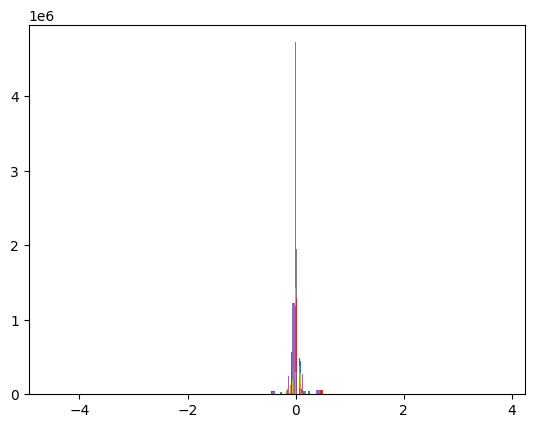

In [18]:
visualize_layer_wise_weights(audio_model)

initial_projection
downsample_layers.0.process_layer.convs.0.conv
downsample_layers.0.process_layer.convs.1.conv
downsample_layers.0.process_layer.convs.2.conv
downsample_layers.0.process_layer.convs.3.conv
downsample_layers.1.input_layers.1
downsample_layers.1.process_layer.convs.0.conv
downsample_layers.1.process_layer.convs.1.conv
downsample_layers.1.process_layer.convs.2.conv
downsample_layers.1.process_layer.convs.3.conv
downsample_layers.2.input_layers.1
downsample_layers.2.process_layer.convs.0.conv
downsample_layers.2.process_layer.convs.1.conv
downsample_layers.2.process_layer.convs.2.conv
downsample_layers.2.process_layer.convs.3.conv
f0_conv_layers.0
f0_conv_layers.1
f0_conv_layers.2
upsample_layers.0.process_layer.convs.1.conv
upsample_layers.0.process_layer.convs.2.conv
upsample_layers.0.process_layer.convs.3.conv
upsample_layers.1.process_layer.convs.1.conv
upsample_layers.1.process_layer.convs.2.conv
upsample_layers.1.process_layer.convs.3.conv
upsample_layers.2.process_

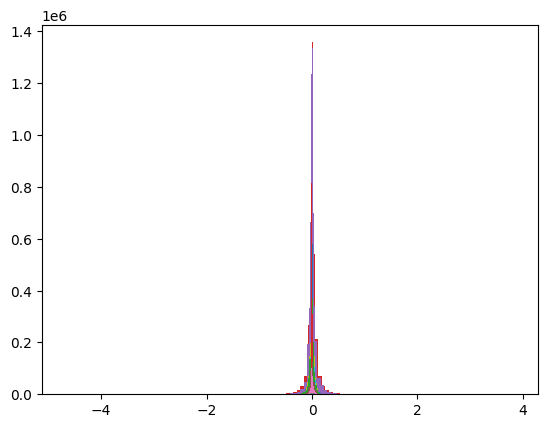

In [20]:
visualize_layer_wise_weights(audio_model)

In [24]:
spectral_loss_val = spectral_loss(audios, torch_gt_audio[:, :audios.shape[1]]).to(device)
spectral_loss_val

tensor(1.7275, device='cuda:0')

In [31]:
audio_model.downsample_layers.modules

<bound method Module.modules of ModuleList(
  (0): ResNetBlock(
    (input_layers): ModuleList(
      (0): Mish()
      (1): AvgPool1d(kernel_size=(8,), stride=(4,), padding=(2,))
    )
    (process_layer): DownSampleLayer(
      (convs): ModuleList(
        (0): ConvBlock(
          (nonlinearity): Mish()
          (conv): Conv1d(512, 512, kernel_size=(8,), stride=(4,), padding=(2,))
          (layers): ModuleList(
            (0): Mish()
            (1): Conv1d(512, 512, kernel_size=(8,), stride=(4,), padding=(2,))
          )
        )
        (1-2): 2 x ConvBlock(
          (nonlinearity): Mish()
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=same)
          (layers): ModuleList(
            (0): Mish()
            (1): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=same)
          )
        )
        (3): ConvBlock(
          (nonlinearity): Mish()
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=same)
          (layers)

In [17]:
audios

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')

In [12]:
from quantize.src import add_range_recoder_hook
hook, input_activations, output_activations = add_range_recoder_hook(audio_model, {}, {})

In [25]:
import copy
def quantize_per_tensor(x, bits=4, min_val=None, max_val=None):
    if min_val is None:
        min_val = x.min()
    if max_val is None:
        max_val = x.max()
    targets = torch.linspace(min_val, max_val, 2**bits).to(x.device)
    differences = torch.abs(x.unsqueeze(-1) - targets)
    nearest_indices = torch.argmin(differences, dim=-1)
    rounded_values = targets[nearest_indices]
    return rounded_values

def quantize_model(net, bits, mode='global'):
  quantized_net = copy.deepcopy(net)
  for name, module in quantized_net.named_modules():
    if isinstance(module, (torch.nn.Conv1d, torch.nn.Linear)):
      if mode == 'global':
        module.weight.data = quantize_per_tensor(module.weight.data, bits=bits)
      elif mode == 'per_channel':
        for i in range(module.weight.data.shape[0]):
          module.weight.data[i] = quantize_per_tensor(module.weight.data[i], bits=bits)
                                                 
  if hasattr(module, 'bias') and module.bias is not None and mode == 'per_channel':
      module.bias.data = quantize_per_tensor(module.bias.data, bits=bits)
  return quantized_net

quantized_global_model_8 = quantize_model(audio_model, 8, mode='per_channel')
torch.max(quantized_global_model_8.initial_projection.weight.data - audio_model.initial_projection.weight.data)

tensor(0.0014, device='cuda:0')

In [26]:
outpus = quantized_global_model_8.sample_cfg(f0.shape[0], f0=f0, num_steps=100, singer=singer_tensor, strength=3, invert_audio_fn=invert_audio_fn)

Resnet Vals:  tensor(-0.5726, device='cuda:0') tensor(0.3698, device='cuda:0')
Resnet Vals:  tensor(0.0058, device='cuda:0') tensor(-0.0713, device='cuda:0')
Resnet Vals:  tensor(-0.1505, device='cuda:0') tensor(-4.9388, device='cuda:0')
Resnet Vals:  tensor(0.0083, device='cuda:0') tensor(-1.7569, device='cuda:0')
Resnet Vals:  tensor(0.0835, device='cuda:0') tensor(-1.4512, device='cuda:0')
Resnet Vals:  tensor(0.0011, device='cuda:0') tensor(-0.0054, device='cuda:0')
Resnet Vals:  tensor(-0.5708, device='cuda:0') tensor(0.3734, device='cuda:0')
Resnet Vals:  tensor(0.0074, device='cuda:0') tensor(-0.0737, device='cuda:0')
Resnet Vals:  tensor(0.0042, device='cuda:0') tensor(-5.0966, device='cuda:0')
Resnet Vals:  tensor(-0.1868, device='cuda:0') tensor(-2.2101, device='cuda:0')
Resnet Vals:  tensor(0.0273, device='cuda:0') tensor(-1.5796, device='cuda:0')
Resnet Vals:  tensor(-0.0003, device='cuda:0') tensor(-0.0064, device='cuda:0')
Resnet Vals:  tensor(-0.5841, device='cuda:0') te

In [24]:
outpus

(tensor([[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],
 
         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],
 
         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],
 
         ...,
 
         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, na

In [30]:
audio = invert_audio_fn(outpus[0])

100%|██████████| 200/200 [00:00<00:00, 365.29it/s]


In [34]:
def get_stft(x, n_fft, hop_length=None):
    """
    Returns the stft of x.
    """
    return torch.stft(x,
                      n_fft=n_fft,
                      hop_length = hop_length,
                      window=torch.hann_window(n_fft).to(device),
                      return_complex=False)

def safe_log(x, eps=1e-7):
    """
    Avoid taking the log of a non-positive number
    """
    safe_x = torch.where(x <= eps, eps, x)
    return torch.log(safe_x)


def log_L1_STFT(x,y, n_fft=512, eps=1e-6, hop_length=None):
    """
    Computes log spectral L1 loss

    Parameters
    ----------
    x: first audio waveform(s), torch.tensor
    y: second audio waveform(s), torch.tensor
    n_fft: n_fft for stft
    hop_length: stft hop length
    eps: added to the magnitude stft before taking the square root. Limits dynamic range of spectrogram.

    Returns
    -------
    loss, float tensor
    """
    est_stft = get_stft(x, n_fft=n_fft, hop_length=hop_length)
    ref_stft = get_stft(y, n_fft=n_fft, hop_length=hop_length)
    
    assert est_stft.shape == ref_stft.shape 

    est_amp = torch.sqrt(est_stft[..., 0]**2 + est_stft[..., 1]**2 + eps)
    ref_amp = torch.sqrt(ref_stft[..., 0]**2 + ref_stft[..., 1]**2 + eps)
    result = torch.mean(torch.abs(safe_log(est_amp)-safe_log(ref_amp)))

    return result

In [32]:
audio.shape

torch.Size([16, 191744])

In [37]:
torch_gt_audio[:, :outpus[0].shape[1]].shape

torch.Size([16, 192])

In [44]:
stft_loss = log_L1_STFT(audio, torch_gt_audio[:, :audio.shape[1]]).to(device)

In [45]:
stft_loss

tensor(2.6921, device='cuda:0')

In [49]:
# extract pitch from the primes
processed_pitch_val = [pitch_task_fn(**{"inputs": {"pitch": {"data": val[0][:2400]}}})['sampled_sequence'] for val in primes['concatenated_array']]
processed_pitch_val = torch.Tensor(np.stack(processed_pitch_val)).reshape(len(processed_pitch_val), 1, processed_pitch_val[0].shape[0])
interpolated_pitch = p2a.interpolate_pitch(pitch=processed_pitch_val, audio_seq_len=audio_seq_len)    # interpolate pitch values to match the audio model's input size
interpolated_pitch = torch.nan_to_num(interpolated_pitch, nan=196)  # replace nan values with silent token
interpolated_pitch = interpolated_pitch.squeeze(1) # to match input size by removing the extra dimension
f0 = interpolated_pitch.float()

# extract singer from the primes
singers = [val[4] for val in primes['concatenated_array']]

[1, 4, 54, 54, 25, 4, 25, 4, 1, 4, 49, 23, 23, 26, 25, 54]